Исследование математической модели, Панкратов Александр, МТ-402

In [1]:
from IPython.display import display
from ipywidgets import *
from IPython.display import Image
from matplotlib import pyplot as plt
import math
import random
from decimal import *
from ctypes import *

lib = '/home/kokamido/Рабочий стол/диплом/ipython/cfunc.so'
cfunc = cdll.LoadLibrary(lib)

cfunc.draw_noisy_curve.restype= POINTER(POINTER(c_longdouble))
cfunc.draw_noisy_curve.argtype = [c_longdouble, c_longdouble, c_longdouble, c_longdouble,
                                  c_longdouble, c_longdouble, c_int]

cfunc.draw_curve.restype= POINTER(POINTER(c_longdouble))
cfunc.draw_curve.argtype = [c_longdouble, c_longdouble, c_longdouble, c_longdouble, c_longdouble, c_int]

cfunc.find_cycle.restype= POINTER(POINTER(c_longdouble))
cfunc.find_cycle.argtype = [c_longdouble, c_longdouble, c_longdouble, c_longdouble, c_int]

In [2]:
p=1
q=1
Step = 0.0001
noise_lvl = 0.00001
singular_point_x = 1
singular_point_y = 1

In [3]:
def curve(x0,y0,n):
    res_x = list()
    res_y = list()
    bufferVals = POINTER(POINTER(c_longdouble))
    bufferVals = cfunc.draw_curve(c_longdouble(Step),
                                        c_longdouble(p),c_longdouble(q),
                                        c_longdouble(x0),c_longdouble(y0),
                                        c_int(n))
    for i in range(0,n):
        res_x.append(bufferVals[0][i])
        res_y.append(bufferVals[1][i])
    cfunc.free_crv_memory()
    return[res_x,res_y]

In [4]:
def curves_y(start_y,end_y,x,step,rk_iter,color='c',lw=1):
    y = start_y
    while y < end_y:
        current_curve = curve(x,y,rk_iter)
        plt.plot(current_curve[0],current_curve[1],color,linewidth=lw)
        y+=step

In [5]:
def curves_x(start_x,end_x,y,step,rk_iter):
    x = start_x
    while x < end_x:
        current_curve = curve(x,y,rk_iter)
        plt.plot(current_curve[0],current_curve[1],'c',linewidth=5)
        x+=step

In [6]:
def curves_circle(num, r,rk_iter, color='c',lw=1):
    for i in range(1,num):
        current_curve = curve(1+r*math.cos(2*math.pi/num*i),1+r*math.sin(2*math.pi/num*i),rk_iter)
        plt.plot(current_curve[0],current_curve[1],color,linewidth=lw)

In [7]:
def euclidean_range(x0,y0,x1,y1):
    return math.sqrt(math.pow(x0-x1,2)+math.pow(y0-y1,2))

'''
def find_cycle(eps,iterations=100000):
    cross = [singular_point_x,singular_point_y+1]
    crv = curve(cross[0],cross[1],iterations); 
    while(True):
        #crv = curve(cross[0],cross[1],iterations);
        crv = curve(crv[0][-1],crv[1][-1],iterations);
        print('new curve')
        res_x = list()
        res_y = list()
        for i in range(0, len(crv[1])-1):
            x0 = crv[0][i]
            y0 = crv[1][i]
            x1 = crv[0][i+1]
            y1 = crv[1][i+1]
            if((y0>=singular_point_y and y1>=singular_point_y) and
            ((x0-singular_point_x) * (x1-singular_point_x) < 0)):
                if (abs(cross[1]-(min(y0,y1)+abs(y0-y1)/(abs(x0-x1)/
                                                     abs((x0 if y0<=y1  else x1)-singular_point_x))))<eps):
                    res_x.append(x1)
                    res_y.append(y1)
                    return [res_x,res_y]
                else:    
                    buf = cross[1]
                    cross[1] = min(y0,y1)+abs(y0-y1)/(abs(x0-x1)/
                                                     abs((x0 if y0<=y1  else x1)-singular_point_x))
                    print(buf-cross[1])
                    res_x = list()
                    res_x.append(x0)
                    res_y = list()
                    res_y.append(y0)
            else:
                res_x.append(x0)
                res_y.append(y0)
'''        

def find_cycle(eps,iterations=100000):
    res_x = list()
    res_y = list()
    print("i am c")
    bufferVals = POINTER(POINTER(c_longdouble))
    bufferVals = cfunc.find_cycle(c_longdouble(p), c_longdouble(q),c_longdouble(Step),
                                  c_longdouble(eps), c_int(iterations))
    n = int(bufferVals[0][0])
    for i in range(1,n):
        res_x.append(bufferVals[0][i])
        res_y.append(bufferVals[1][i])
    cfunc.free_crv_memory()
    return[res_x,res_y]
    
def F11(x,y):
    return -y

def F12(x,y):
    return -x

def F21(x,y):
    return p*y

def F22(x,y):
    return p*x-2*p/math.pow((1+y),2)

# в качестве z0,z1 берутся 0, 1 или 1,0
def vector_for_monodromy(z0,z1,cycle): #cycle[0], cycle[1]-- координаты точки из цикла, cycle[2]-- количество точек в цикле
    #i=0
    #z00 = z0 + Step*(F11(x[0], y[0])*z0 + F12(x[0], y[0])*z1)
    #z11 = z1 + Step*(F11(x[0], y[0])*z0 + F12(x[0], y[0])*z1)
    #pair = [z00, z11]
    x = cycle[0]
    y = cycle[1]
    i=0
    z00 = z0
    z11 = z1
    while i<len(cycle[1]):
        #pair = euler(pair, x[i], y[i])
        z0 = z00
        z1 = z11
        z00 = z0 + Step*(F11(x[i], y[i])*z0 + F12(x[i], y[i])*z1)
        z11 = z1 + Step*(F21(x[i], y[i])*z0 + F22(x[i], y[i])*z1)
        i+=1
    pair = [z00, z11]
    return pair

def multiplier(vector1, vector2):
    a = vector1[0]
    b = vector1[1]
    c = vector2[0]
    d = vector2[1]
    print([[a,b],[c,d]])
    discr = (a+d)*(a+d)-4*(a*d-b*c)
    if discr>=0:
        lambda1 = (a+d+math.sqrt(discr))*0.5
        lambda2 = (a+d-math.sqrt(discr))*0.5
    else:
        lambda1 = 0
        lambda2 = 0
    return [lambda1, lambda2]

def get_multiplier():
    cycle = find_cycle(0.0001)
    vector_ab = vector_for_monodromy(0,1,cycle)
    vector_cd = vector_for_monodromy(1,0,cycle)
    return multiplier(vector_cd, vector_ab)
    

def norm(vec):
    nor = euclidean_range(0,0,vec[0],vec[1])
    return[vec[0]/nor,vec[1]/nor]

import cmath
def eugenvalues(M):
    #print(M)
    disc_sqrt = cmath.sqrt(math.pow(M[0][0]+M[1][1],2)-4*(M[0][0]*M[1][1]-M[1][0]*M[0][1]))
    if(disc_sqrt.imag > 0):
        print("img = "+str(disc_sqrt.imag))
    disc_sqrt = disc_sqrt.real
    return[(M[0][0]+M[1][1]+disc_sqrt)/2, (M[0][0]+M[1][1]-disc_sqrt)/2]

def is_stable(cycle):
    a_b = Euler([1,0],cycle)
    c_d = Euler([0,1],cycle)
    return Andronov_Hopf_condition([[a_b[0],a_b[1]],[c_d[0],c_d[1]]])#([[a_b[0],c_d[0]],[a_b[1],c_d[1]]])

In [8]:
import random
import math
random.seed()
def normal_dist_random_values():
    x = random.random()
    y = random.random()
    
    a = math.sqrt(-2*math.log(x))*math.cos(2*math.pi*y)
    b = math.sqrt(-2*math.log(x))*math.sin(2*math.pi*y)
    return [a,b]
noise_lvl = 0.01

def noisy_curve(x0,y0,n):
    res_x = list()
    res_y = list()
    bufferVals = POINTER(POINTER(c_longdouble))
    bufferVals = cfunc.draw_noisy_curve(c_longdouble(noise_lvl),c_longdouble(Step),
                                        c_longdouble(p),c_longdouble(q),
                                        c_longdouble(x0),c_longdouble(y0),
                                        c_int(n))
    for i in range(0,n):
        res_x.append(bufferVals[0][i])
        res_y.append(bufferVals[1][i])
    cfunc.free_crv_memory()
    return[res_x,res_y]

def avg(list_arg):
    return sum(list_arg)/len(list_arg)

def expectancy(crv):
    return [avg(crv[0]),avg(crv[1])]

from functools import reduce
def dispersion(crv):
    exp = expectancy(crv)
    centr_curve = [map(lambda x: x-exp[0],crv[0]), map(lambda x: x-exp[1],crv[1])]
    return [reduce(lambda y,x: x*x+y,centr_curve[0])/len(crv[0]),reduce(lambda y,x: x*x+y,centr_curve[1])/len(crv[0])]

In [9]:
def time_row(vals):
    times = [i*Step for i in range(0,len(vals))]
    plt.plot(times,vals)

In [10]:
#
#plt.xlim(left_bound, right_bound)
#plt.ylim(bottom_bound,top_bound)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0]=10
fig_size[1]=10
#

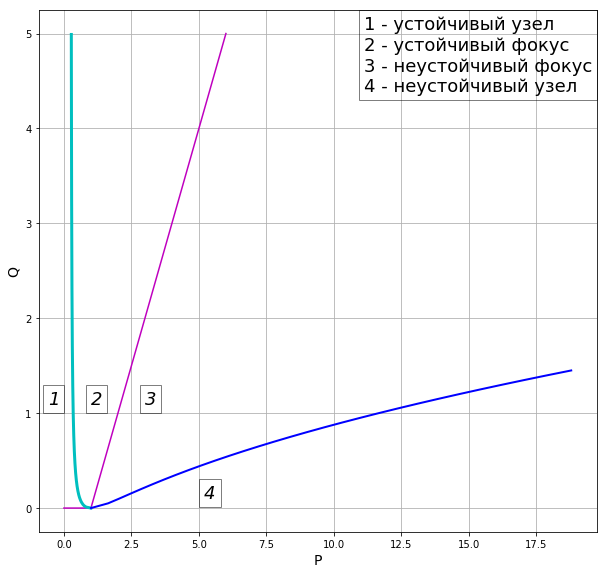

In [66]:
def p1(q):
    return math.pow(math.sqrt(q/(q+1))-1,2)/math.pow(q/(q+1)-1,2)
def p2(q):
    return math.pow(math.sqrt(q/(q+1))+1,2)/math.pow(q/(q+1)-1,2)
stable_p = [0,1,2,3,4,5,6]
stable_q = [0,0,1,2,3,4,5]
q_1 = list(map(lambda x: x/100,range(0,500)))
q_2 = list(map(lambda x: x/20,range(0,30)))
p1_p = list(map(lambda x: p1(x),q_1))
p2_p = list(map(lambda x: p2(x),q_2))  

fig = plt.figure()
ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)
ax.text(-0.6, 1.1, '1', style='italic',fontsize=18, bbox={'facecolor':'none', 'alpha':0.5, 'pad':5})
ax.text(1, 1.1, '2', style='italic',fontsize=18, bbox={'facecolor':'none', 'alpha':0.5, 'pad':5})
ax.text(3, 1.1, '3', style='italic',fontsize=18, bbox={'facecolor':'none', 'alpha':0.5, 'pad':5})
ax.text(5.19, 0.11, '4', style='italic',fontsize=18, bbox={'facecolor':'none', 'alpha':0.5, 'pad':5})
ax.text(11.1, 4.39, '1 - устойчивый узел\n2 - устойчивый фокус\n3 - неустойчивый фокус\n4 - неустойчивый узел'
        ,fontsize=18, bbox={'facecolor':'none', 'alpha':0.5, 'pad':5})
plt.plot(stable_p,stable_q,'m')
p_1_graph = plt.plot(p1_p,q_1,'c', lw=3)
p_2_graph = plt.plot(p2_p,q_2,'b',lw=2)
plt.grid()
plt.xlabel('P',fontsize=14)
plt.ylabel('Q',fontsize=14)
plt.show()
#при й = 0.1, пересечения: 0.590..., 1.1, 2.0496..

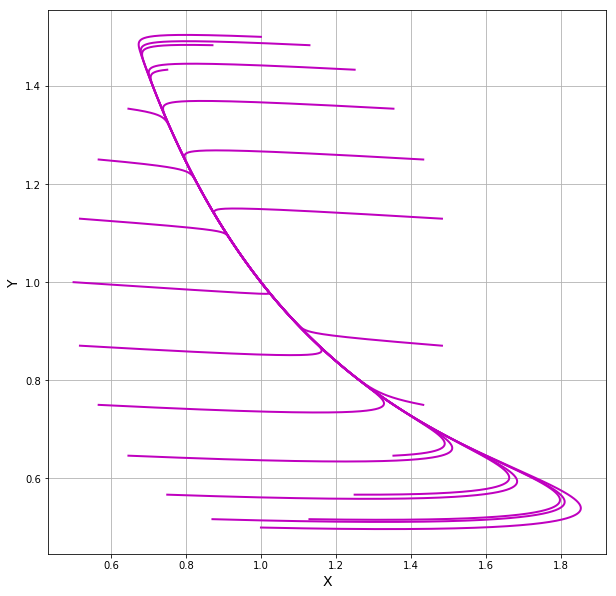

In [14]:
#Это рисовать портреты
buf = p
p = 0.05
Step = 0.01

curves_circle(24, 0.5, 200000,color='m', lw=2)
ax = plt.axes()
p = buf
plt.grid()
plt.xlabel('X',fontsize=14)
plt.ylabel('Y',fontsize=14)
plt.show()
fig_size = plt.rcParams["figure.figsize"]
fig_size[0]=10
fig_size[1]=10

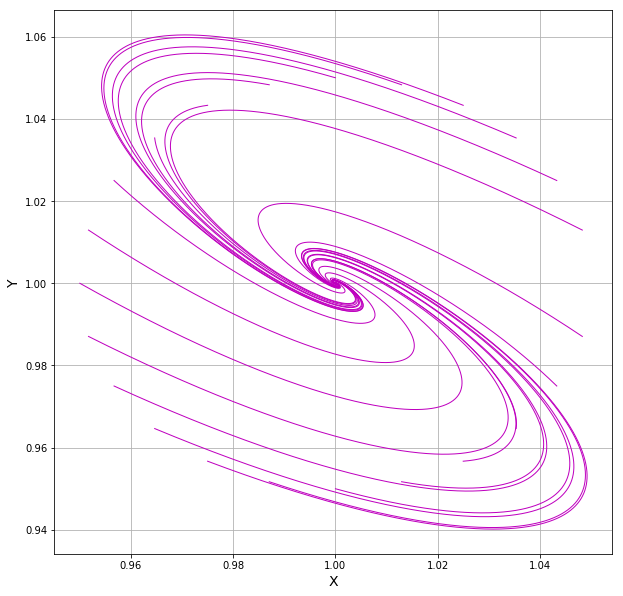

In [71]:
#Это рисовать портреты
buf = p
p = 0.7
Step = 0.001
#curves_y(0.95, 0.97, 0.9, 0.005, 100000,color='m', lw=2)
#curves_y(1.03, 1.05, 1.1, 0.005, 100000)
curves_circle(24, 0.05, 50000,color='m', lw=1)

ax = plt.axes()
#plt.axes().arrow(singular_point_x,singular_point_y,0,0.00000001,head_width=0.01, head_length=0.01,lw = 0,color='g')
p = buf
plt.grid()
plt.xlabel('X',fontsize=14)
plt.ylabel('Y',fontsize=14)
plt.show()

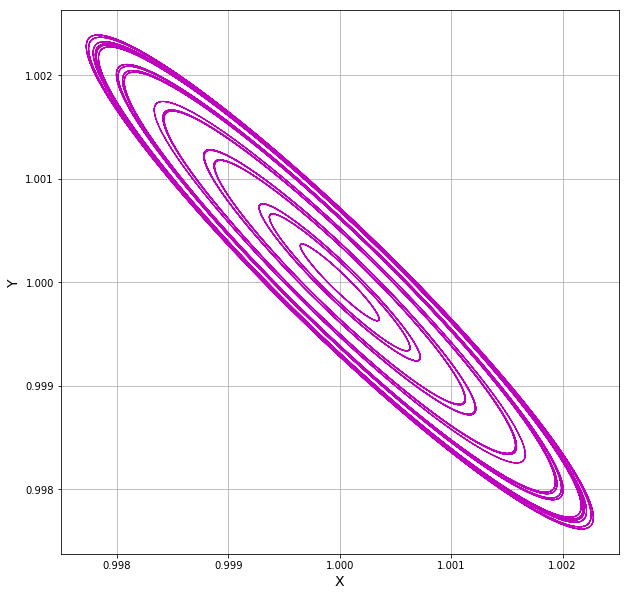

In [85]:
#Это рисовать портреты
buf = p
q = 0.1
p = 1.1
Step = 0.001
curves_circle(24, 0.0005, 100000,color='m', lw=1)
ax = plt.axes()
#plt.axes().arrow(singular_point_x,singular_point_y,0,0.00000001,head_width=0.001, head_length=0.001,lw = 0,color='g')
p = buf
plt.grid()
plt.xlabel('X',fontsize=14)
plt.ylabel('Y',fontsize=14)
plt.show()

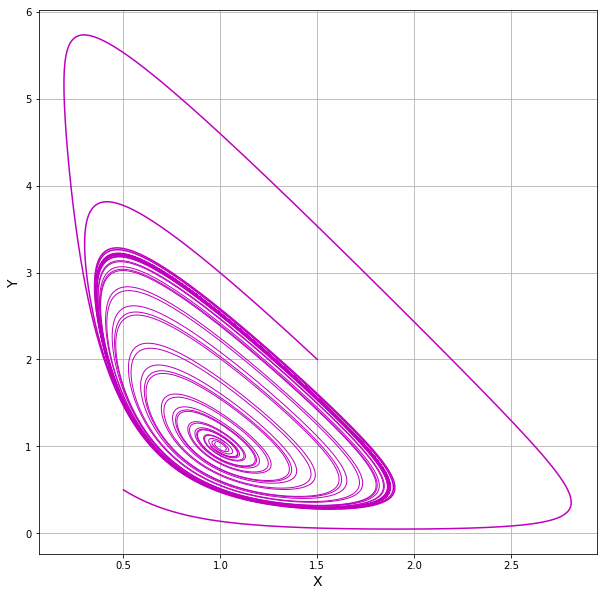

In [14]:
#Это рисовать портреты
buf = p
q=1
p = 2.5
Step = 0.001
#curves_y(0.985, 0.995, 0.99, 0.005, 4000,color='m', lw=1)
#curves_y(1.01, 1.02, 1.01, 0.005, 10000)
crv = curve(1.5,2,1000000)
plt.plot(crv[0],crv[1],color='m')
crv = curve(0.5,0.5,1000000)
plt.plot(crv[0],crv[1],color='m')
curves_circle(6,0.05,1000000,color='m')
ax = plt.axes()
#plt.axes().arrow(singular_point_x,singular_point_y,0,0.00000001,head_width=0.001, head_length=0.001,lw = 0,color='m')
p = buf
plt.grid()
plt.xlabel('X',fontsize=14)
plt.ylabel('Y',fontsize=14)
plt.show()

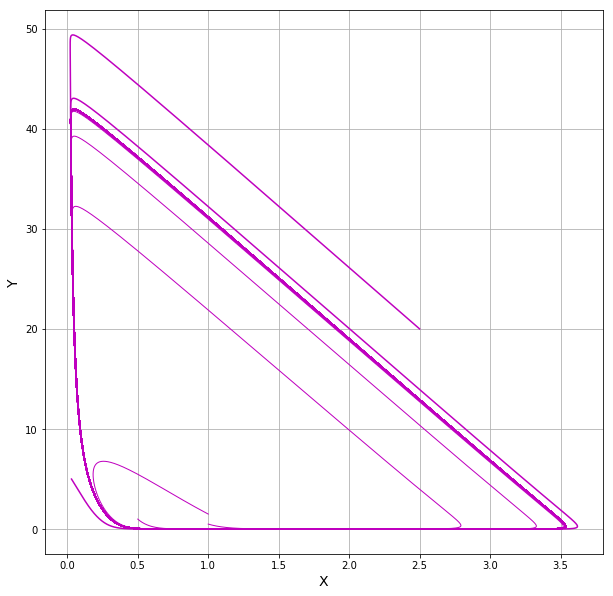

In [18]:
#Это рисовать портреты
buf = p
p = 12.5
q=1
Step = 0.001
#curves_y(0.985, 0.995, 0.99, 0.005, 4000,color='m', lw=1)
#curves_y(1.01, 1.02, 1.01, 0.005, 10000)
crv = curve(0.03,5,1000000)
plt.plot(crv[0],crv[1],color='m')
crv = curve(2.5,20,1000000)
plt.plot(crv[0],crv[1],color='m')
curves_circle(4,0.5,1000000,color='m')
ax = plt.axes()
plt.grid()
plt.xlabel('X',fontsize=14)
plt.ylabel('Y',fontsize=14)
p = buf
plt.show()

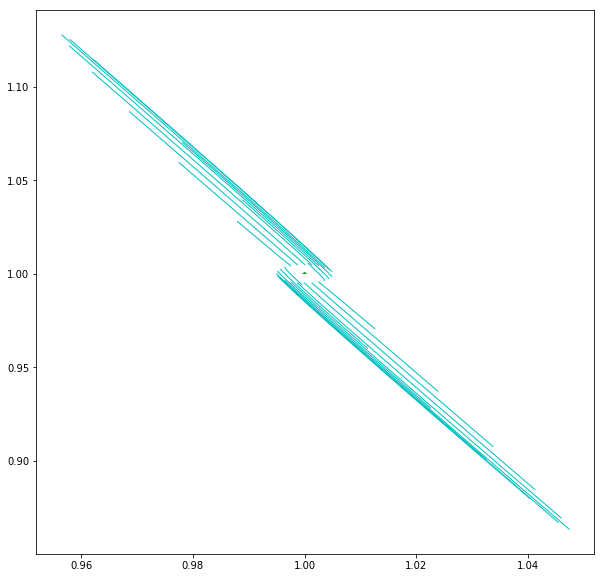

In [40]:
#Это рисовать портреты
buf = p
p = 3
Step = 0.001
#curves_y(0.985, 0.995, 0.99, 0.005, 4000,color='m', lw=1)
#curves_y(1.01, 1.02, 1.01, 0.005, 10000)
curves_circle(24,0.005,1500)
ax = plt.axes()
plt.axes().arrow(singular_point_x,singular_point_y,0,0.00000001,head_width=0.001, head_length=0.001,lw = 0,color='g')
p = buf
plt.show()

i am c
[[1.0263305448696822, -0.058218675306719446], [0.02279349300683527, 0.9477132806004572]]
[1.0017922069712488, 0.9722516184988905]
i am c
[[1.5372876507236506, -1.483527321751813], [0.3793436432043227, -0.048291735457845826]]
[1.0009133207538328, 0.488082594511972]
i am c
[[2.094400399389333, -3.1530565422262318], [0.65199173367684, -0.8786318908339769]]
[1.000266017781579, 0.21550249077377726]
i am c
[[2.7037193496137033, -5.054848200630372], [0.8842302145645115, -1.623218415959768]]
[0.999541330824999, 0.08095960282893633]
i am c
[[3.3536237854710507, -7.219389924305521], [1.0854986484362295, -2.3291723785013323]]
[0.9989546372324151, 0.025496769737303304]
i am c
[[4.0280284414709735, -9.675239917465355], [1.2592954096199198, -3.0231053113392017]]
[0.9980789426558907, 0.006844187475881114]
i am c
[[4.705347399127121, -12.40323101848202], [1.4062384954144542, -3.7064803470905154]]
[0.9972392936638554, 0.0016277583727504208]
i am c
[[5.372142274788344, -15.373821839368883], [1.52

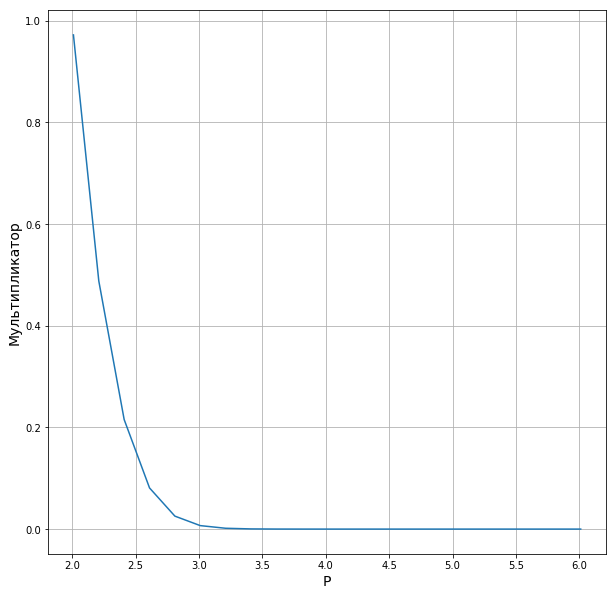

In [68]:
q = 1
muls = list()
ps = list()
for i in range (0,21):
    p = 2.01+0.2*i
    ps.append(p)
    Step = 0.0005
    mul = get_multiplier()
    print(mul)
    muls.append(mul[1])
plt.grid()
plt.xlabel('P',fontsize=14)
plt.ylabel('Мультипликатор',fontsize=14)
plt.plot(ps,muls)
plt.show()

3
i am c


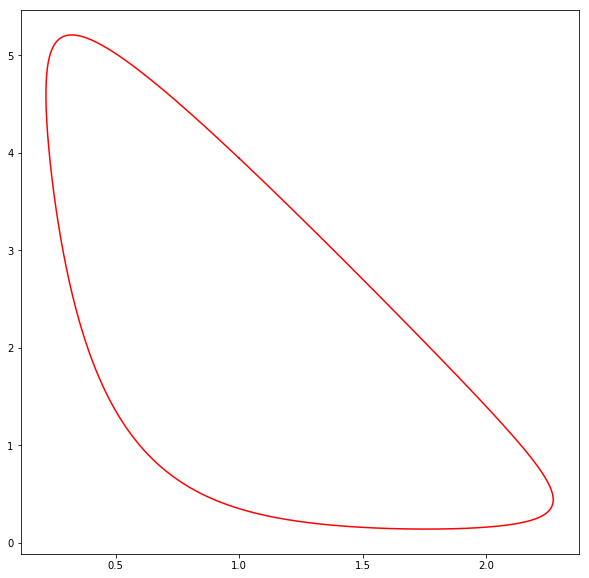

63440
12
i am c


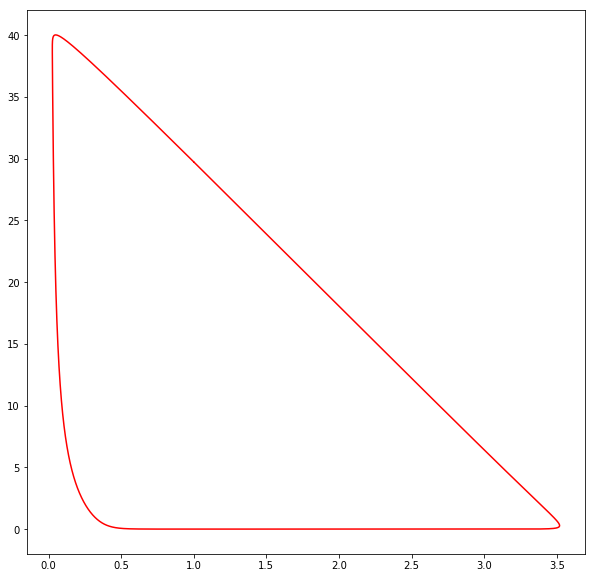

In [19]:
#Это рисовать портреты
buf = p
p = 3
q=1
Step = 0.0001
#curves_y(0.985, 0.995, 0.99, 0.005, 4000,color='m', lw=1)
#curves_y(1.01, 1.02, 1.01, 0.005, 10000)
for i in range(0,1):
    print(p)
    #curves_circle(2,0.01,10000000,color='c')
    #curves_circle(2,0.5,2500000,color='m')
    cyc1 = find_cycle(0.00001,iterations=10000000)
    
    plt.plot(cyc1[0],cyc1[1],c='r')
    plt.show()
    print(len(cyc1[0]))
    p = 12
    print(p)
    cyc2 = find_cycle(0.00001,iterations=10000000)
    
    plt.plot(cyc2[0],cyc2[1],c='r')
    plt.show()
    #print(len(cyc2[0]))
    #curves_circle(2,0.01,10000000,color='c')
    
    #cyc = find_cycle(0.001)
    #plt.plot(cyc[0],cyc[1],c='m')
    #plt.show()
    #p = p+0.000000000001
p = buf


1.133329961035
i am c


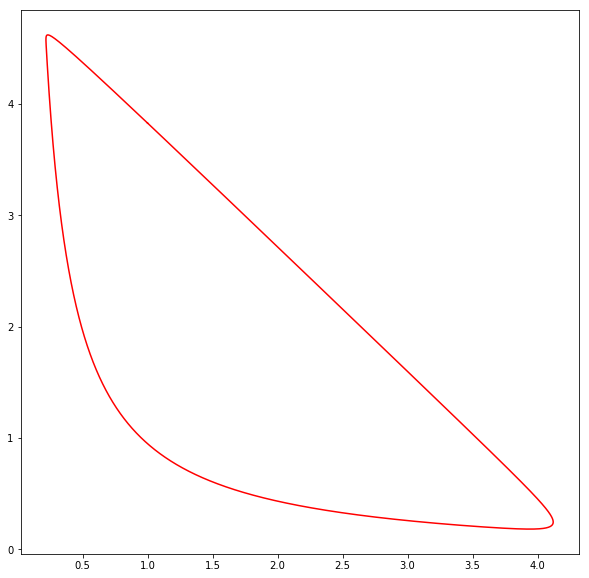

708104
1.133329961036
i am c


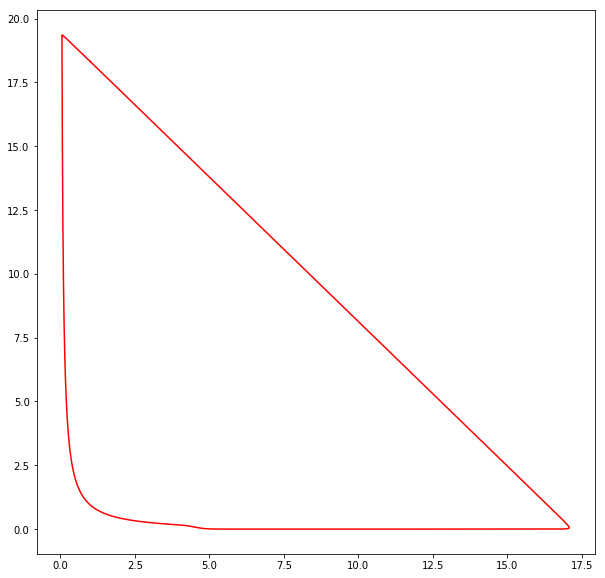

In [16]:
#Это рисовать портреты
buf = p
p = 1.133329961035
q=0.1
Step = 0.0001
#curves_y(0.985, 0.995, 0.99, 0.005, 4000,color='m', lw=1)
#curves_y(1.01, 1.02, 1.01, 0.005, 10000)
for i in range(0,1):
    print(p)
    #curves_circle(2,0.01,10000000,color='c')
    #curves_circle(2,0.5,2500000,color='m')
    cyc1 = find_cycle(0.00001,iterations=10000000)
    
    plt.plot(cyc1[0],cyc1[1],c='r')
    plt.show()
    print(len(cyc1[0]))
    p = 1.133329961036
    print(p)
    cyc2 = find_cycle(0.00001,iterations=10000000)
    
    plt.plot(cyc2[0],cyc2[1],c='r')
    plt.show()
    #print(len(cyc2[0]))
    #curves_circle(2,0.01,10000000,color='c')
    
    #cyc = find_cycle(0.001)
    #plt.plot(cyc[0],cyc[1],c='m')
    #plt.show()
    #p = p+0.000000000001
p = buf


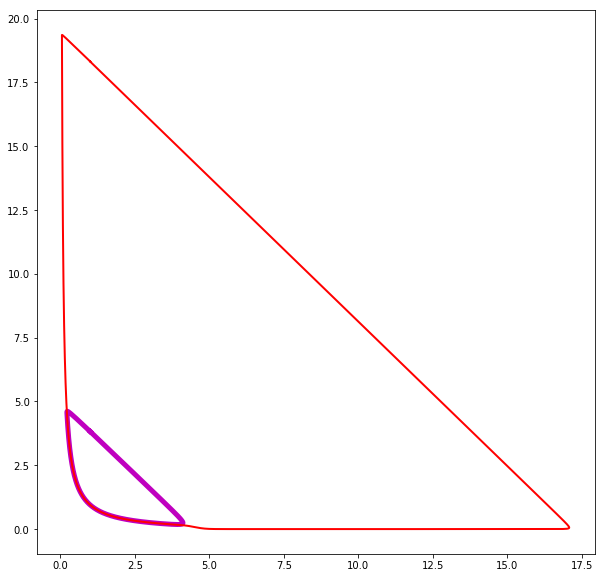

In [28]:
plt.plot(cyc1[0],cyc1[1],c='m',lw=5)
plt.plot(cyc2[0],cyc2[1],c='r',lw=2)
plt.show()

1.1333299610345
new curve
-1.7544520042770562
0.9973537748141382


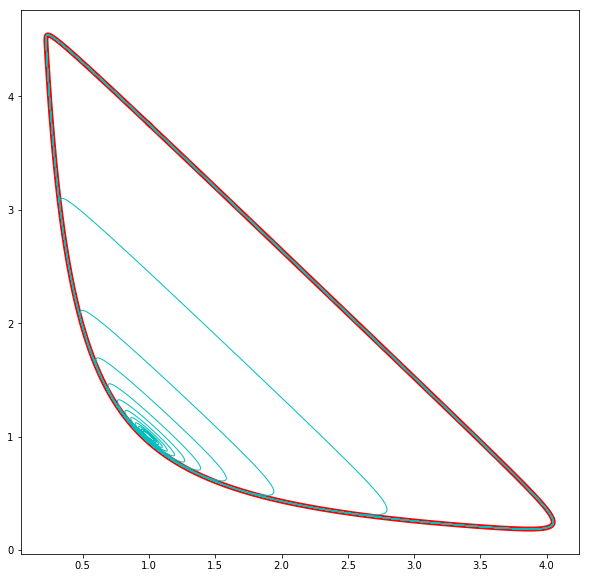

1.133329961036
new curve
-16.32007674305106


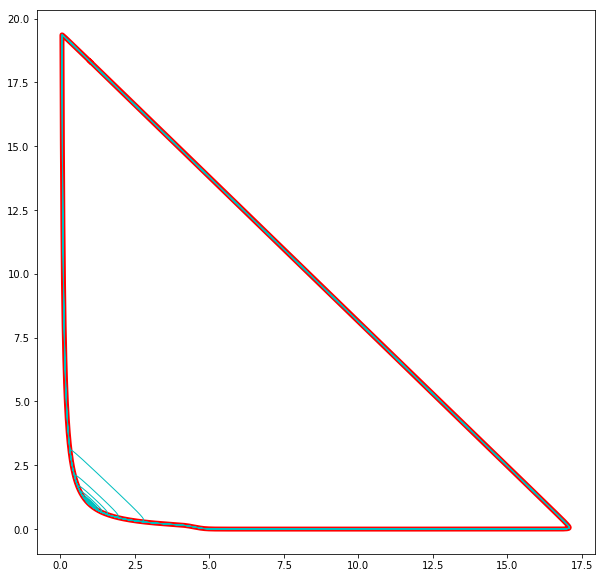

In [16]:
#Это рисовать портреты
buf = p
p = 1.1333299610345
q=0.1
Step = 0.0001
for i in range(0,1):
    print(p)
    cyc = find_cycle(0.00001, 10000000)
    print(cyc[0][10])
    plt.plot(cyc[0],cyc[1],c='r',lw=5)
    curves_circle(2,0.01,10000000,color='c')
    plt.show()
    p = 1.133329961036
    print(p)
    cyc = find_cycle(0.00001, 10000000)
    plt.plot(cyc[0],cyc[1],c='r',lw=5)
    curves_circle(2,0.01,10000000,color='c')
    plt.show()
p = buf


In [20]:
from decimal import *
Decimal(2)/Decimal(3)

Decimal('0.6666666666666666666666666667')